parent indices: [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  

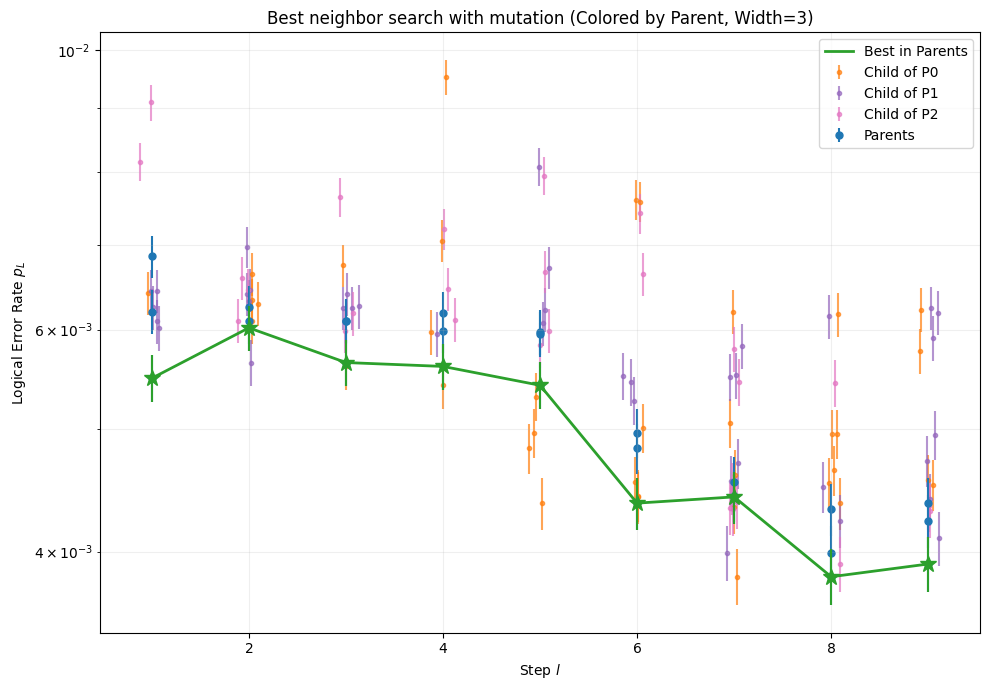

In [23]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Settings
filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
BEAM_WIDTH = 3             

# Define distinct colors for the children of each parent
PARENT_COLORS = ['tab:orange', 'tab:purple', 'tab:pink']

def plot_beam_search_colored(filepath, code_name):
    with h5py.File(filepath, "r") as f:
        if code_name not in f:
            print(f"Code {code_name} not found. Available: {list(f.keys())}")
            return
        grp = f[code_name]
        
        # Load datasets
        lers = grp["logical_error_rates"][:]
        stds = grp["logical_error_rates_std"][:]
        summaries = grp["step_summaries"][:] 
        survivor_indices_table = grp["beam_survivors"][:] 
        
        # Robustly handle missing parent_idx
        if "parent_idx" in grp:
            parent_indices = grp["parent_idx"][:]
        else:
            print("Warning: 'parent_idx' not found. Defaulting to 0.")
            parent_indices = np.zeros(len(lers), dtype=int)

        print(f"parent indices: {parent_indices}")
        steps_data = []
        
        # --- ALIGNMENT FIX ---
        # The simulation initializes both datasets with a "dummy/seed" row at index 0.
        # summaries[0] is [0,0,0,-1] (empty). survivors[0] is the start state.
        # The actual search steps start at index 1.
        
        num_steps = min(len(summaries), len(survivor_indices_table))
        
        print(f"Found {len(summaries)} summary rows and {len(survivor_indices_table)} survivor rows.")
        print(f"Plotting iterations starting from index 1...")

        # Start loop at 1 to skip the initialization row
        for i in range(1, num_steps):
            row = summaries[i]
            start_idx = int(row[0])
            count = int(row[1])
            
            # Slice data for this step (The Cloud)
            cloud_lers = lers[start_idx : start_idx + count]
            cloud_stds = stds[start_idx : start_idx + count]
            cloud_parents = parent_indices[start_idx : start_idx + count]

            # Get survivors for this SAME step index
            step_survivor_indices = survivor_indices_table[i]
            
            step_survivors = []
            for global_idx in step_survivor_indices:
                # Filter out -1 paddings and validity check
                if global_idx != -1 and global_idx < len(lers):
                    step_survivors.append((lers[global_idx], stds[global_idx]))
            
            best_of_step = min(step_survivors, key=lambda x: x[0]) if step_survivors else None
            
            steps_data.append({
                "step_num": i,
                "cloud_lers": cloud_lers,
                "cloud_stds": cloud_stds,
                "cloud_parents": cloud_parents,
                "survivors": step_survivors,
                "best_of_step": best_of_step
            })

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 1. Plot the "Search Cloud" (COLORED BY PARENT)
    for data in steps_data:
        step_x = data["step_num"]
        
        if len(data["cloud_lers"]) > 0:
            x_vals = np.ones(len(data["cloud_lers"])) * step_x
            # Add jitter
            jitter = np.random.normal(0, 0.06, size=len(x_vals))
            
            for p_id in range(BEAM_WIDTH):
                mask = (data["cloud_parents"] == p_id)
                print(f"Step {step_x}, Parent {p_id}: Plotting {np.sum(mask)} points.")
                print(f"cloud parents: {data['cloud_parents']}")
                print(f"mask: {mask}")
                if np.any(mask):
                    ax.errorbar(x_vals[mask] + jitter[mask], 
                                data["cloud_lers"][mask], 
                                yerr=data["cloud_stds"][mask], 
                                fmt='o', 
                                color=PARENT_COLORS[p_id % len(PARENT_COLORS)], 
                                alpha=0.7, # Slightly transparent to see density
                                ms=3, 
                                zorder=0,
                                label=f'Child of P{p_id}' if step_x==1 else "")

    # 2. Plot Survivors (Blue Dots)
    for data in steps_data:
        step_x = data["step_num"]
        for survivor in data["survivors"]:
            ax.errorbar(step_x, survivor[0], yerr=survivor[1],
                        fmt='o', color='tab:blue', alpha=1.0, ms=5, zorder=1, label='Parents' if step_x==1 else "")

    # 3. Plot Best Path (Green Line)
    best_x = []
    best_y = []
    best_yerr = []
    
    for data in steps_data:
        if data["best_of_step"]:
            best_x.append(data["step_num"])
            best_y.append(data["best_of_step"][0])
            best_yerr.append(data["best_of_step"][1])

    if best_x:
        ax.plot(best_x, best_y, color='tab:green', linestyle='-', linewidth=2, zorder=2, label='Best in Parents')
        ax.errorbar(best_x, best_y, yerr=best_yerr, fmt='*', color='tab:green', ms=12, zorder=3)

    # Styling
    ax.set_yscale('log')
    ax.set_xlabel('Step $l$')
    ax.set_ylabel('Logical Error Rate $p_L$')
    ax.set_title(f'Best neighbor search with mutation (Colored by Parent, Width={BEAM_WIDTH})')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Legend (Deduplicated)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_beam_search_colored(filepath, code_name)